# Load and test pre-trained models



In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import SymLogNorm
from tensorflow.keras.models import load_model

import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess
from src.model import transform_batch, plot_history

models_path = "../../models/"

In [15]:
datestring = "2024_06_03T092350"
model_path = os.path.join(models_path,datestring) + ".keras"
model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,203 (12.52 KB)

 Trainable params: 1,063 (4.15 KB)

 Non-trainable params: 12 (48.00 B)

 Optimizer params: 2,128 (8.32 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K])'>,
        <Axes: title={'center': 'Last 15 epochs'}, xlabel='Epoch', ylabel='mse [K]'>],
       dtype=object))

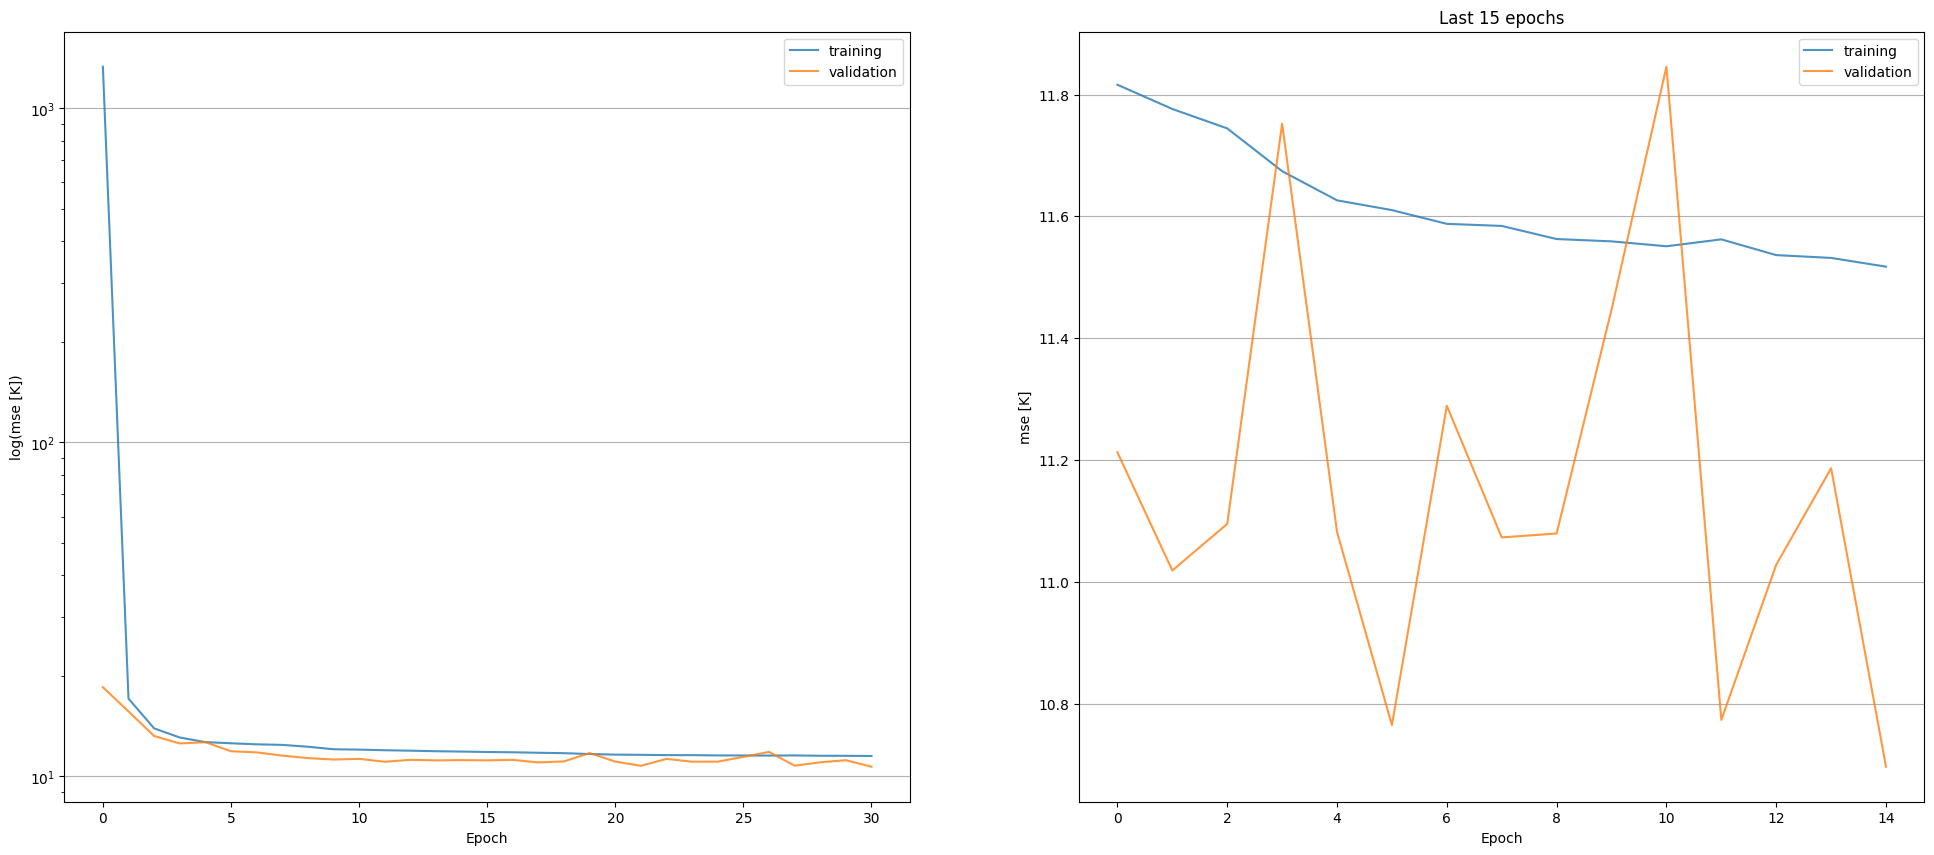

In [16]:
# Load and plot training history
history_path = os.path.join(models_path, datestring) + "_history"
with open(history_path, "rb") as file:
    history = pickle.load(file)
plot_history(history)


In [17]:

folder_path = "../../data/raw/Daily_Windsat/"
# Load windsat dataset, and trasnform it to feed it to the model
ds = windsat_datacube(folder_path)
ascds = model_preprocess(ds)

ascds_df = ascds.to_dataframe()
ascds_df.reset_index(inplace=True)
ascds_df.dropna(inplace=True)
ascds_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)

transfomed_df = transform_batch(ascds_df)

# Remove the time of observation, FOR SOME MODELS
transfomed_df = transfomed_df[
    [col for col in transfomed_df.columns if col not in 
        ["time_18Ghz","time_37Ghz","day_number"]
    ]
]

# Predict on the model and append the predicted srutep
ascds_df["surtep_MODEL"] = model.predict(transfomed_df[[col for col in transfomed_df.columns if col != "surtep_ERA5"]])
ascds_df["error"] = ascds_df["surtep_ERA5"] - ascds_df["surtep_MODEL"]
ascds_df

41286/41286 ━━━━━━━━━━━━━━━━━━━━ 33s 799us/step


,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,surtep_MODEL,error
212694,1,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,5.365944e+08,5.365944e+08,288.132355,-12.237915
232835,1,276.849609,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,5.365944e+08,5.365945e+08,288.296570,-11.446960
232838,1,277.820099,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,5.365944e+08,5.365945e+08,286.212433,-8.392334
232839,1,278.050476,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,5.365944e+08,5.365944e+08,286.400055,-8.349579
232840,1,277.954346,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,5.365944e+08,5.365944e+08,287.261108,-9.306763
...,...,...,...,...,...,...,...,...,...,...,...,...
24771688,349,279.382294,70.625,22.125,198.187500,130.512497,208.532501,153.035004,5.666628e+08,5.666628e+08,274.722198,4.660095
24771689,349,279.180969,70.625,22.375,204.407501,142.735001,210.417496,160.252502,5.666628e+08,5.666628e+08,272.697845,6.483124
24771690,349,278.574554,70.625,22.625,208.712494,151.412506,212.059998,165.992493,5.666628e+08,5.666628e+08,270.521973,8.052582
24771691,349,276.485809,70.625,22.875,210.847504,155.565002,212.977493,169.082489,5.666628e+08,5.666628e+08,268.907318,7.578491


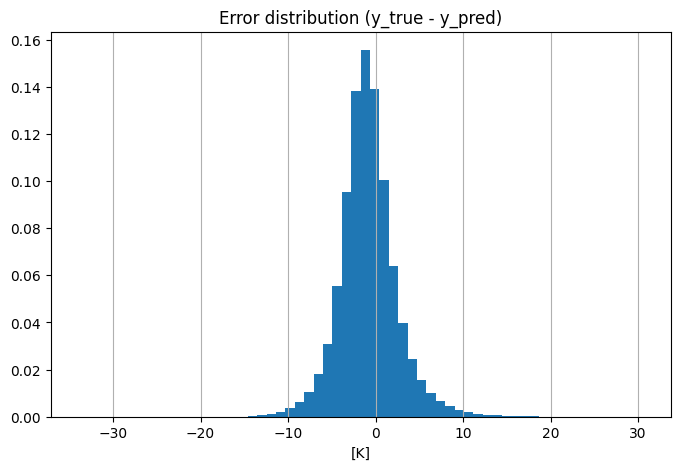

In [18]:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = ascds_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

### NOTE:
Since the testing dataset is Jan 1st to Jan 21st, the mse should be biased towards negative values (aka, day_number is not doing anything ... )

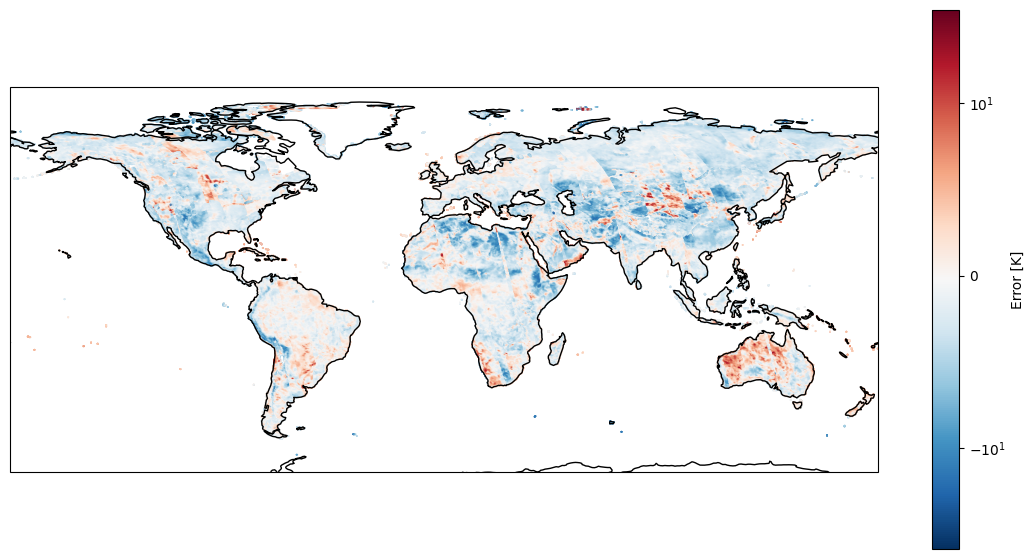

In [19]:
# Testing by predicting the whole dataset:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = SymLogNorm(linthresh=11)

scatter = ax.scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()


### Some areas with poor performance

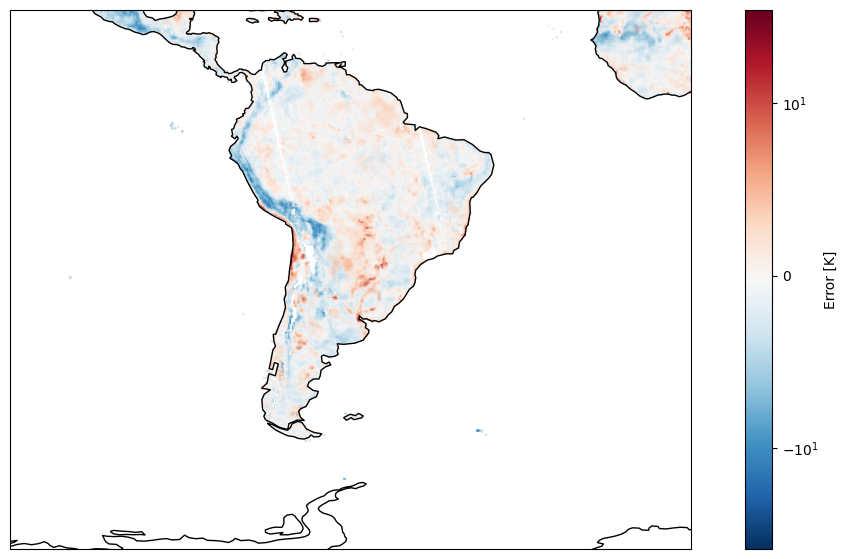

In [20]:
south_america = [(-75,20),(-120,0)]

ax.set_ylim(south_america[0])
ax.set_xlim(south_america[1])

fig

### This consistent over-estimation of the temperature in high grounds could be due to the model not beeing altitude-aware

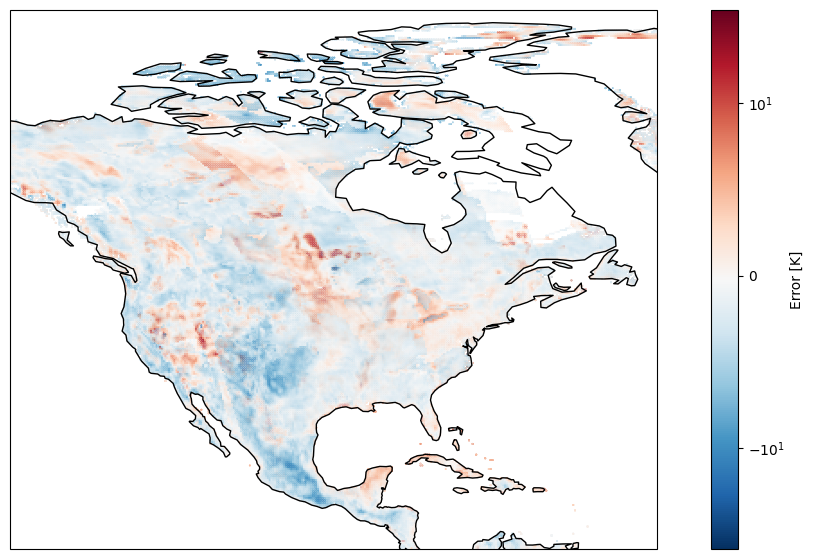

In [21]:
# Selec some problematic areas:
north_america = [(10,85),(-140,-50)]

ax.set_ylim(north_america[0])
ax.set_xlim(north_america[1])

fig

### Big lakes (Michigan) mess up the model too, we should remove Water bodies from training, maybe  also in validation.

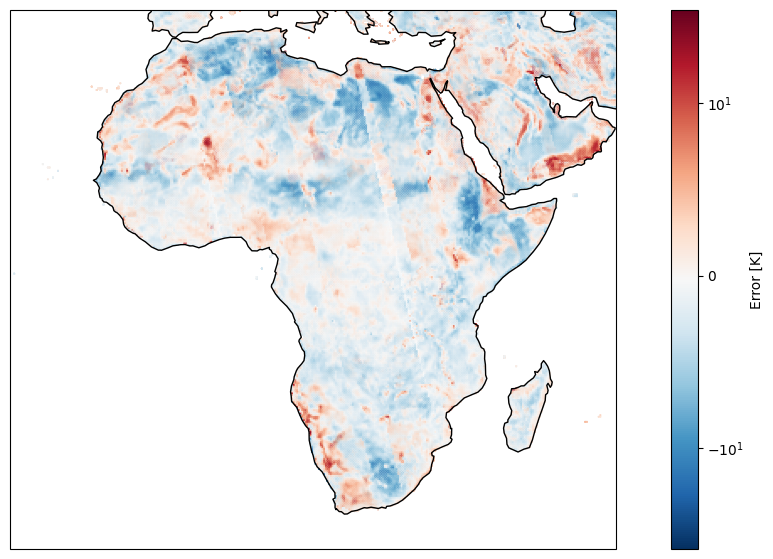

In [22]:
central_africa = [(-40,40),(-30,60)]

ax.set_ylim(central_africa[0])
ax.set_xlim(central_africa[1])

fig

### Some very high error (predicted temp is hoter than measured) near the small lakes in central africa.

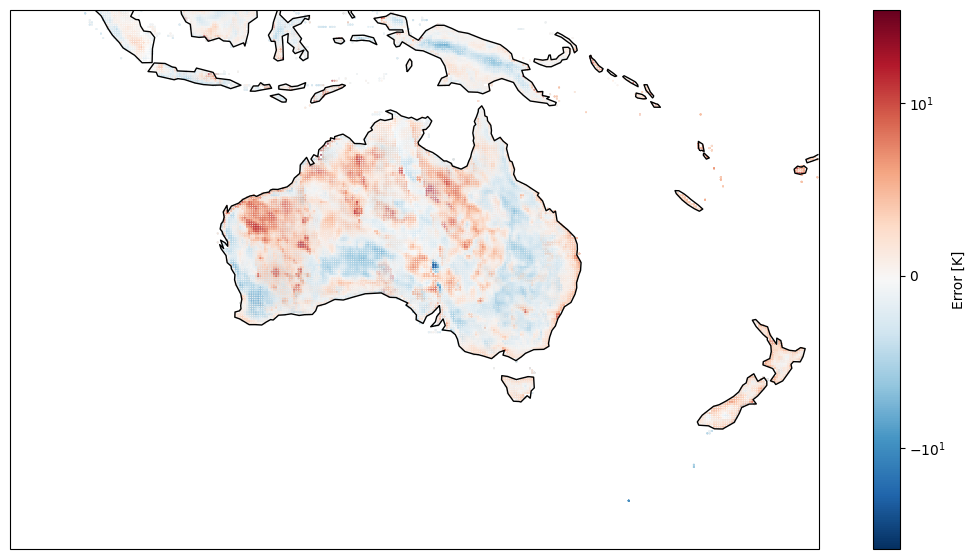

In [23]:
australia = [(-60,0),(90,180)]

ax.set_ylim(australia[0])
ax.set_xlim(australia[1])

fig

#### Lets plot the surtep from ERA5 and the model side by side to see if the features are a product of the real data or not

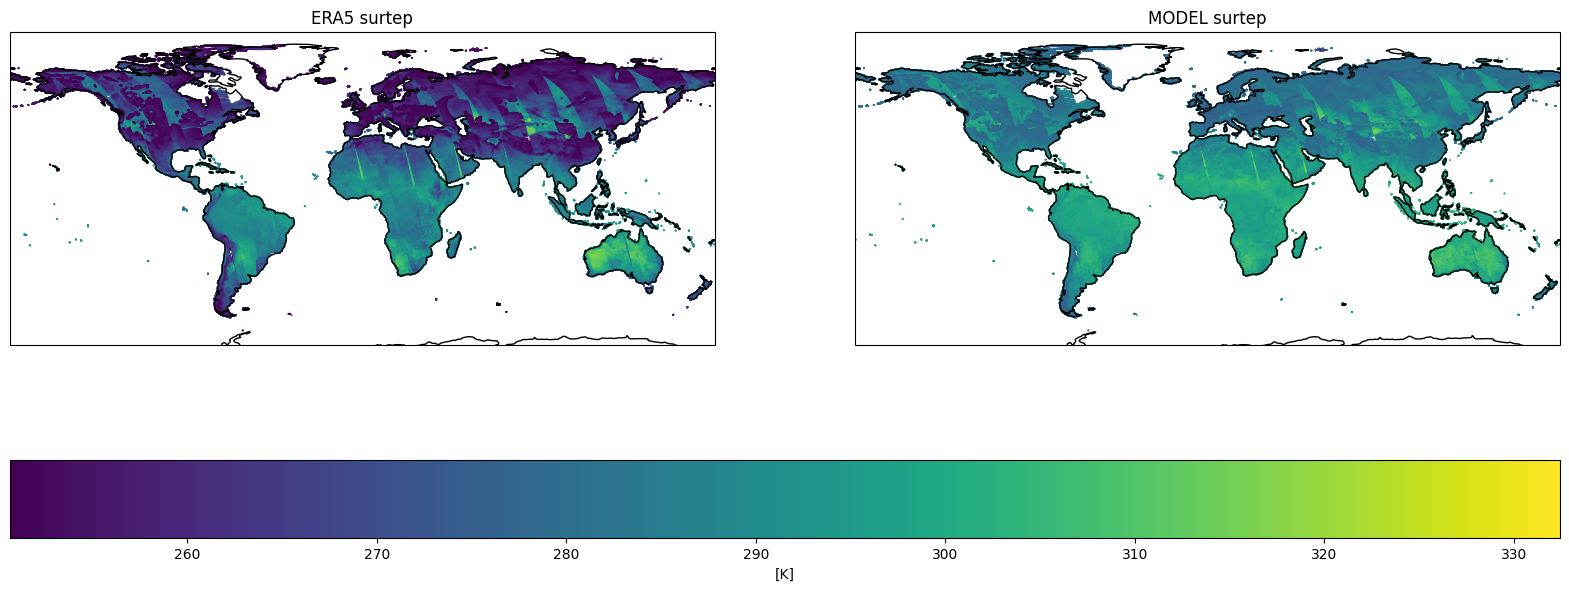

In [24]:
# Testing by predicting the whole dataset:
fig, ax = plt.subplots(1,2,figsize = (20,10), subplot_kw={"projection":ccrs.PlateCarree()} )

ax[0].coastlines("110m")
ax[1].coastlines("110m")

scatter = ax[0].scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["surtep_ERA5"],
    cmap = "viridis",
)
ax[0].set_title("ERA5 surtep")

scatter = ax[1].scatter(
    x = ascds_df["lon"],
    y =ascds_df["lat"],
    s= 0.1,
    alpha = 1,
    c=ascds_df["surtep_MODEL"],
    cmap = "viridis",
)
ax[1].set_title("MODEL surtep")


fig.colorbar(scatter, ax=ax, orientation='horizontal', label='[K]')
plt.show()

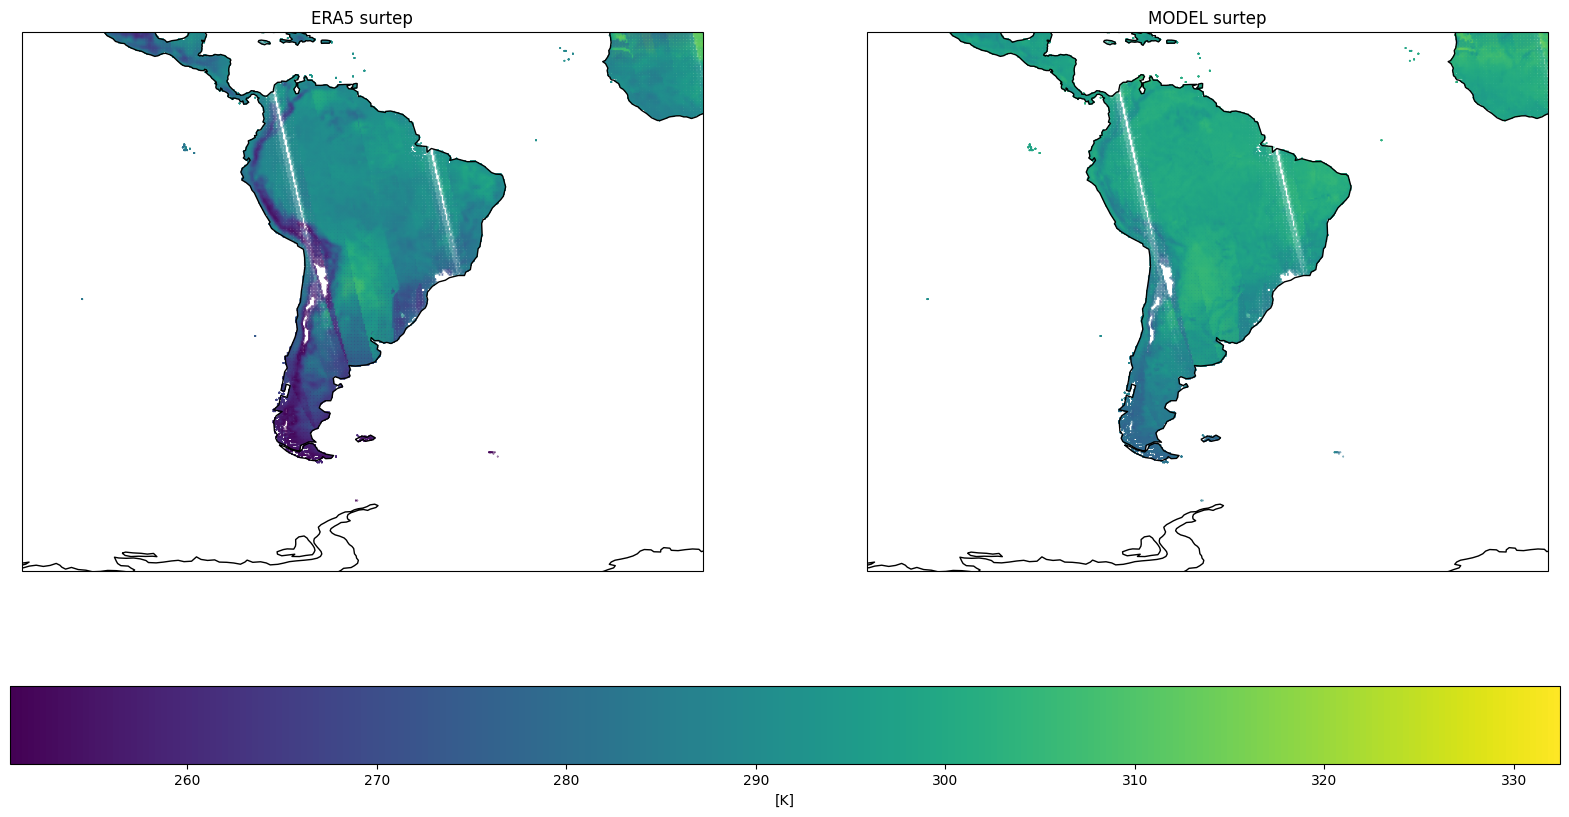

In [25]:
south_america = [(-75,20),(-120,0)]

ax[0].set_ylim(south_america[0])
ax[0].set_xlim(south_america[1])

ax[1].set_ylim(south_america[0])
ax[1].set_xlim(south_america[1])

fig

--- 

# MODEL VERSION 2: 

Winsat tbtoa + TELSEM emissivities

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import CenteredNorm
from tensorflow.keras.models import load_model

import xarray as xr
import pandas as pd
import numpy as np
import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess, telsem_datacube, doy2month_mapping
from src.model import plot_history, xy_split

models_path = "../../models/"

# Select ascending (0) or descending (1) pass
swath = 0

In [14]:
# Load a model
# datestring = "WSMv2_D_2024_06_28T184126"
datestring = "WSMv2_A_2024_06_28T184738"
model_path = os.path.join(models_path, datestring + ".keras")
history_path = os.path.join(models_path, datestring + "_history")

model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 60)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,995 (35.14 KB)

 Trainable params: 2,991 (11.68 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 5,984 (23.38 KB)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='log(mse [K²])'>,
        <Axes: title={'center': 'Epochs after loss < 20'}, xlabel='Epoch', ylabel='mse [K²]'>],
       dtype=object))

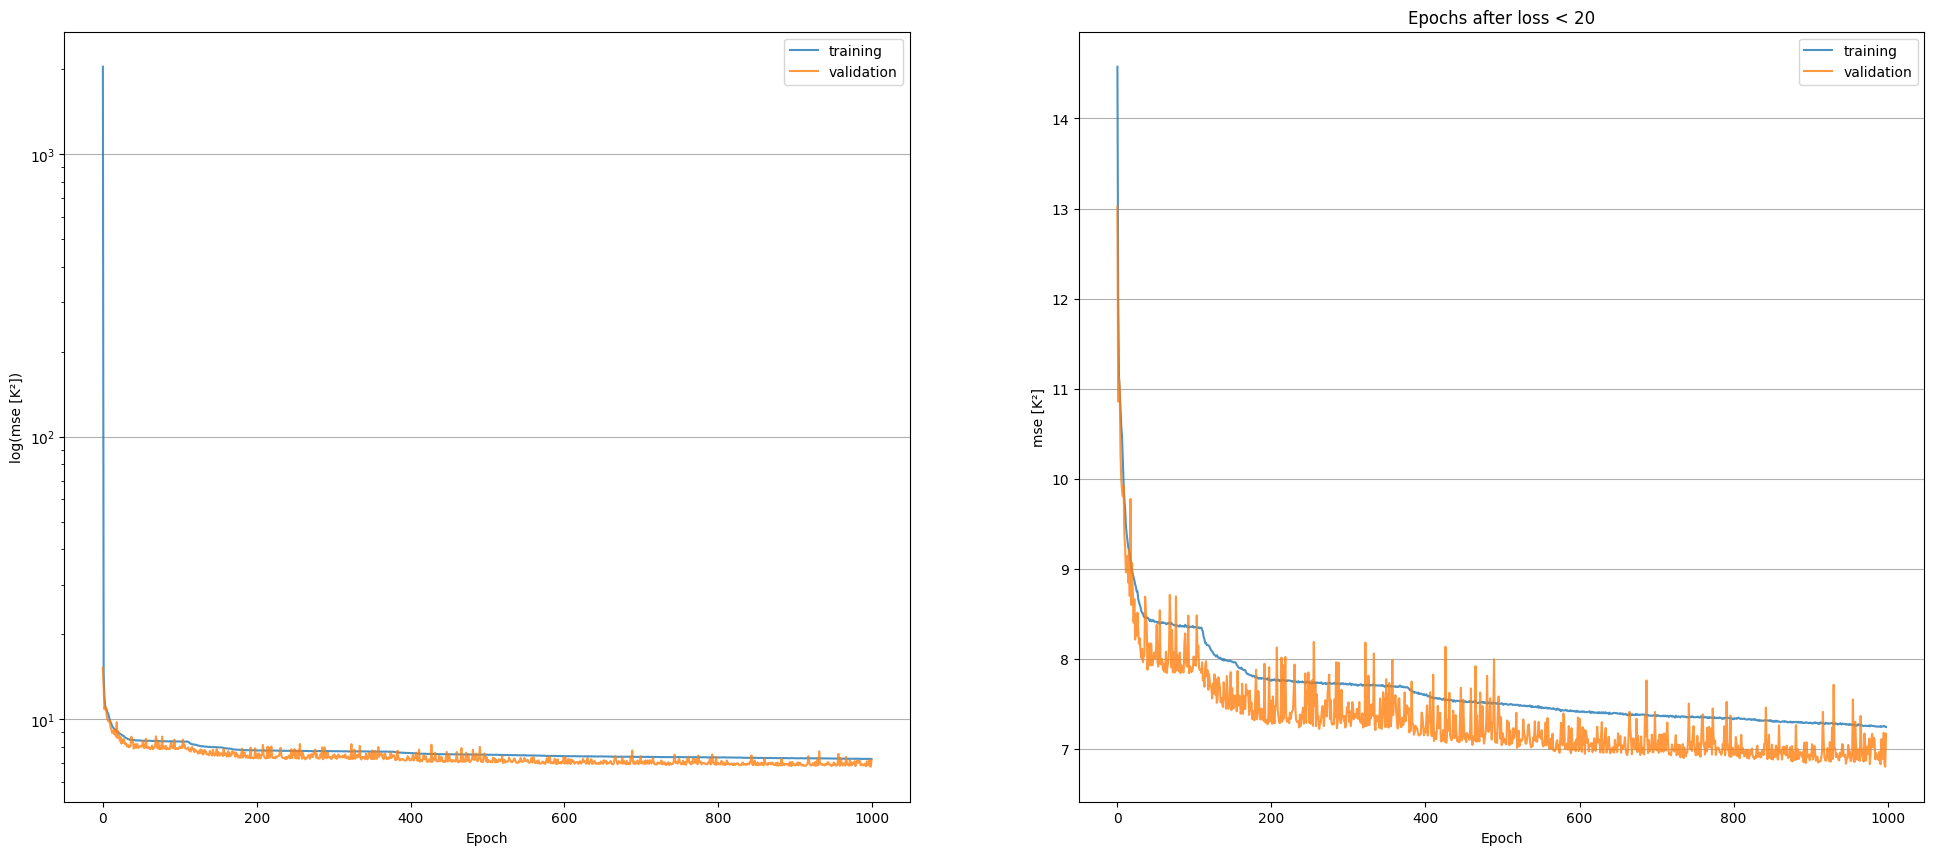

In [15]:
# Training history
with open(history_path, "rb") as file:
    history = pickle.load(file)

plot_history(history, loss_threshold = 20)

In [5]:
#TELSEM ATLAS
telsem_folder = r"..\..\data\processed\WindsatEmiss"

# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)

telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")


In [16]:
# WINDSAT data
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path, look=None)
swath_sd= model_preprocess(ds, swath_sector=swath)

# Select the variables from windsat that we need:
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

swath_sd = swath_sd[d_vars]

swath_df = swath_sd.to_dataframe().dropna().reset_index("day_number")

day_mapping = doy2month_mapping()

swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.646831,0.384178,0.728075,0.499101
1,286.504700,-52.125,299.625,226.136017,181.116562,237.195679,199.574356,0.766709,0.595761,0.818902,0.673376
2,285.798737,-52.125,300.375,226.611542,180.978912,238.014069,199.999802,0.810449,0.670419,0.834964,0.702682
3,285.345428,-51.875,300.125,239.678406,204.687469,248.563171,220.121918,0.793805,0.642822,0.817769,0.671116
4,285.551025,-51.875,300.625,240.952301,208.183792,249.369049,221.831299,0.800585,0.656406,0.816299,0.671582
...,...,...,...,...,...,...,...,...,...,...,...
1675637,279.382294,70.625,22.125,198.187500,130.512497,208.532501,153.035004,0.669632,0.419112,0.707013,0.448490
1675638,279.180969,70.625,22.375,204.407501,142.735001,210.417496,160.252502,0.670714,0.420704,0.707621,0.449943
1675639,278.574554,70.625,22.625,208.712494,151.412506,212.059998,165.992493,0.671796,0.422296,0.708228,0.451395
1675640,276.485809,70.625,22.875,210.847504,155.565002,212.977493,169.082489,0.672878,0.423889,0.708836,0.452847


TODO: Flowchart of this whole process, good for understanding and for the Thesis

In [17]:
# For the majority of models, lat lon are tranformed as folows: 
""" lat = sin(lat), lon = sin(lon)"""

# Save the original lat lon for plotting later
lat = combined_df["lat"].copy()
lon = combined_df["lon"].copy()

combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

In [18]:
# Predict for the local sample and plot:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

52364/52364 ━━━━━━━━━━━━━━━━━━━━ 38s 726us/step


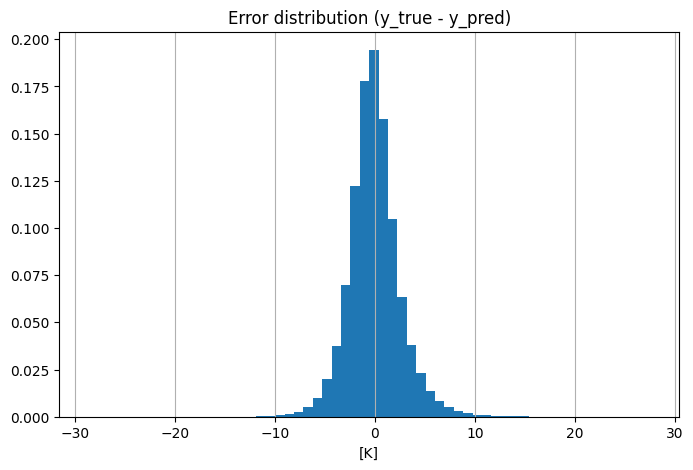

In [19]:
# Error histogram:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60
)
ax.grid(axis="x")
ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
plt.show()

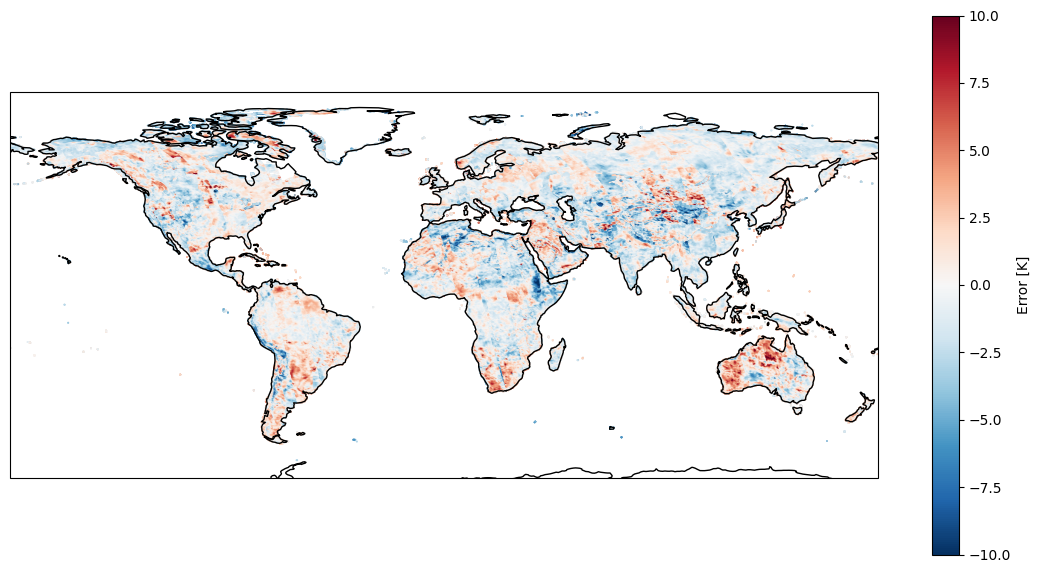

In [21]:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0,halfrange=10, clip = False)

scatter = ax.scatter(
    x = lon,
    y = lat,
    s= 0.1,
    alpha = 1,
    c = combined_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()


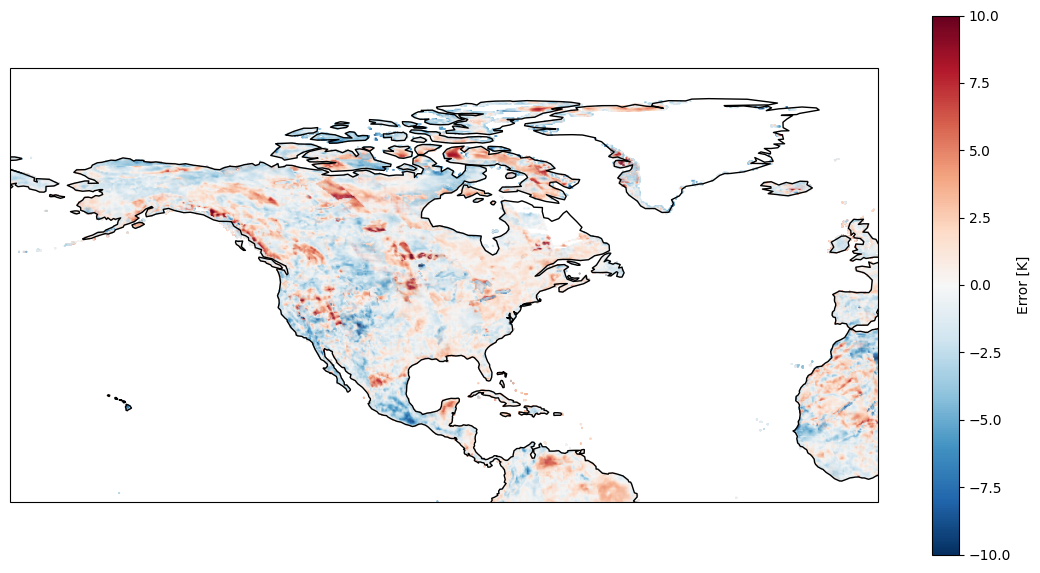

In [22]:
selected_area = [(0,90),(-180,0)]

ax.set_ylim(selected_area[0])
ax.set_xlim(selected_area[1])

fig

In [11]:
# Variable importance
# This gives us an idea on how much the model is relying on each variable for prediction.

from sklearn.inspection import permutation_importance
results = permutation_importance(
    model, X, y,
    scoring="neg_median_absolute_error",
    max_samples= 0.1, # We have a lot of data, use only 10 % 
    n_repeats=3
)


40291/40291 ━━━━━━━━━━━━━━━━━━━━ 35s 870us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 881us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 848us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 824us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 828us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 904us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 809us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 828us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 798us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 808us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 844us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 3s 825us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 873us/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 4s 964us/step
4029/4029 ━━━━━━━━━━━

In [12]:
# Show results
importance = results.importances_mean
for i, v in enumerate(importance):
    print(f"Feature: {X.columns[i]}, score: {v:.5f}")

Feature: lat, score: 0.79450
Feature: lon, score: 0.13592
Feature: tbtoa_18Ghz_V, score: 5.62189
Feature: tbtoa_18Ghz_H, score: 2.55145
Feature: tbtoa_37Ghz_V, score: 3.16109
Feature: tbtoa_37Ghz_H, score: 2.03114
Feature: Emis19V, score: 0.59636
Feature: Emis19H, score: 0.62120
Feature: Emis37V, score: 0.82890
Feature: Emis37H, score: 0.80987


In [ ]:
# TODO: Error histogram for each IGBP landcover class
igpb_path = "../../data/processed/regridded.h5" 
igbp_ds = xr.open_dataset(igpb_path)


<xarray.Dataset> Size: 4MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    spatial_ref  int32 4B ...
    IGBP         (y, x) float32 4MB ...
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...